**ПРОГНОЗИРОВАНИЕ УРОВНЯ ГЛЮКОЗЫ В КРОВИ ЖИВОТНОГО ПРИ ЗАБОЛЕВАНИИ САХАРНЫМ ДИАБЕТОМ С ИПОЛЬЗОВАНИЕМ МЕТОДОВ МАШИННОГО ОБУЧЕНИЯ.**

**Задача:** построение модели машинного обучения, позволяющей осуществить проверку схемы заместительной инсулинотерапии, применяемой для регулирования уровня глюкозы в крови животного с заболеванием сахарным диабетом.

**Параметры прогноза:** модель должна быть оптимизирована для прогноза уровня глюкозы на следующие 24 часа (горизонт прогноза) при заданном объёме вводимого инсулина и времени инъекции. Необходимо предусмотреть возможность изменения интервала прогнозирования (горизонта прогноза) в случае изменения схемы заместительной инсулинотерапии. Средняя абсолютная ошибка (MAE) прогноза модели на интервале 24 часа должна составлять менее 5 ммоль/л.

**Факторы, влияющие на уровень глюкозы:** дозировка и периодичность введения животному инсулина, остаточная секреция инсулина в организме животного, время, объем и качество потребляемой пищи и жидкости, стресс, прием дополнительных препаратов, срок и условия хранения вскрытого инсулина.

**Описание животного и среды обитания:** источником данных об уровне глюкозы является кот породы «Невская маскарадная», кличка - Лексус. Возраст животного составляет около 10 лет, вес - 10 кг, заболевание сахарным диабетом диагностировано ветеринарным врачом в декабре 2022 года. Лечение животного осуществляется путём подкожного введения инсулина (Лантус). Рекомендовано введение инсулина два раза в сутки с интервалом около 12 часов. Животное не выходит за пределы квартиры, имеет постоянный открытый доступ к воде и пище. 

**Описание данных:** данные находятся в таблице insulin_31_05_23.xlsx. В таблицу занесены дата и время измерений - столбец  'injection_datetime', уровень глюкозы (ммоль/л.) - столбец 'glucose_level' и объём введеного инсулина (в ед.) - столбец 'insulin_dose'. Для измерения уровня глюкозы использовался глюкометр марки 'Контур ТС'


Импортируем необходимые библиотеки и модули

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

Определим глобальные переменные

In [46]:
LAG = 100 # количество лагов
ROLLING = 24 # размер окна скользящего среднего
MIN_ROW = 5000 # минимальное число строк для обучения модели
SEED = 42 # зафиксируем значение генератора случайных чисел

Загрузка данных и первичное ознакомление

In [47]:
data = pd.read_excel('D:\datasets\insulin_31_05_23.xlsx')

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   injection_datetime  316 non-null    object 
 1   glucose_level       316 non-null    float64
 2   insulin_dose        316 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.5+ KB


In [49]:
data.head()

,injection_datetime,glucose_level,insulin_dose
0,2023-05-31 20:58:00,30.6,3.5
1,2023-05-30 17:54:00,18.9,3.5
2,2023-05-30 06:35:00,20.4,3.5
3,2023-05-29 20:39:00,20.8,3.5
4,2023-05-29 06:38:00,21.3,3.5


In [50]:
data.tail()

,injection_datetime,glucose_level,insulin_dose
311,2022-12-15 18:17:00,29.0,2.0
312,2022-12-15 05:36:00,20.6,2.0
313,2022-12-14 18:21:00,32.2,2.0
314,2022-12-13 05:15:00,21.3,0.0
315,2022-12-12 17:41:00,33.0,2.0


In [51]:
data.describe()

,glucose_level,insulin_dose
count,316.000000,316.000000
mean,19.924114,3.063608
std,6.114100,1.145608
min,3.100000,0.000000
25%,16.400000,3.000000
50%,19.750000,3.500000
75%,24.100000,3.500000
max,33.000000,4.500000


In [52]:
# стандартное отклонение значений уровня глюкозы
yerr = data['glucose_level'].std()

In [53]:
# список праздничных дней
holiday_dates = ['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-02-23', '2023-02-24',
                 '2023-03-08', '2023-05-01', '2023-05-08', '2023-05-09', '2023-06-12', '2023-11-06']

**Предобработка данных**

Создадим функцию для предобработки данных (data_preprocessing).
Описание работы функции:

1. Приведение столбца injection_datetime к формату datetime.
2. Сортировка данных: данные сортируются по возрастанию времени инъекции.
3. Округление времени до ближайшего 30-минутного интервала.
4. Установка даты и времени в качестве индекса.
5. Сохранение исходных значений уровня глюкозы в столбец glucose_level_true перед интерполяцией.
6. Ресемплинг и заполнение пропусков интерполяцией: данные ресемплируются на 30-минутные интервалы, затем пропуски в столбцах glucose_level и insulin_dose заполняются интерполяцией.
7. Создание столбца с днем недели dayofweek.
8. Определение типа дня (праздничный или будний): cоздается функция is_holiday, которая возвращает 'holiday' для выходных и праздничных дней и 'weekday' для остальных дней. С использованием этой функции создается столбец day с типом дня.
9. Создание столбца с длительностью между инъекциями инсулина.
10. Создание дополнительного столбца - произведение времени после инъекции и содержания инсулина в крови

После применения функции будут созданы столбцы:
- учитывающие влияние проводимой инсулинотерапии (duration_after_insulin_dose, insulin_level, insulin_level_duration);
- учитывающие образ жизни и поведение животного - сезонность (hour, day, dayofweek)

In [54]:
def data_preprocessing(df):
    
    # приводим 'injection_datetime' к формату datetime
    df['injection_datetime'] = pd.to_datetime(df['injection_datetime'])

    # сортируем данные по возрастанию
    df = df.sort_values(by='injection_datetime', ascending=True)[:-1]
    df = df.reset_index(drop=True)

    # сдвинем значения в стобце insulin_dose на один шаг, поскольку на уровень глюкозы влияет кол-во инсулина введенного при предыдущем измерении   
    df['insulin_dose_lag'] = df['insulin_dose'].shift(-1)
    
    # округление времени до ближайшего 30-минутного интервала
    df['injection_datetime'] = df['injection_datetime'].dt.round('30min')

    # установка даты и времени в качестве индекса
    df = df.set_index('injection_datetime')

    # сохраним данные о визмеренных уровней глюкозы, чтобы отличать их от значений определенных интерполяцией
    df['glucose_level_true'] = df['glucose_level']

    # ресемплинг и заполнение пропусков интерполяцией
    df = df.resample('30T').mean()
    df['glucose_level'] = df['glucose_level'].interpolate(method='polynomial', order=2)
    df[['insulin_dose', 'insulin_dose_lag']] = df[['insulin_dose', 'insulin_dose_lag']].fillna(0)

    # создаем столбцы счасом и днём недели 
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.strftime('%A')
        
    # Напишем функцию, которая возвращает 'holiday' в случае, если день выходной или праздничный, 'weekday' - в остальные дни
    def is_holiday(date):
        
    # проверяем, является ли день выходным (суббота - индекс 5) и вхождения в список праздничных дней
        if (date.weekday() >= 5) or (date.date() in pd.to_datetime(holiday_dates).date):  
            return 'holiday'
        return 'weekday'

    df['day'] = df.index.to_series().apply(is_holiday)

    # создание дополнительного столбца с длительностью (в часах) после инъекции инсулина (до следующей инъекции)
    df['duration_after_insulin_dose'] = 0.0
    count = 0

    for i in range(len(df)):
        if df['insulin_dose'][i] == 0:
            df['duration_after_insulin_dose'][i] = count
            count += 0.5
        else:
            df['duration_after_insulin_dose'][i] = count
            count = 0.5

    # создание дополнительного столбца с содержанием инсулина в крови
    df['insulin_level'] = 0

    for i in range(len(df)):
        if df['insulin_dose'][i] != 0:
            end_index = min(i + 24, len(df))  # определим конечный индекс, учитывая размер датафрейма
            df['insulin_level'][i+1:end_index] += df['insulin_dose'][i]/24     
    
    # создание дополнительного столбца - произведение времени после инъекции и содержания инсулина в крови
    df['insulin_level_duration'] = df['insulin_level']*df['duration_after_insulin_dose']

    return df


Проведем предобработку данных

In [55]:
data = data_preprocessing(data)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8168 entries, 2022-12-12 17:30:00 to 2023-05-31 21:00:00
Freq: 30T
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   glucose_level                8168 non-null   float64
 1   insulin_dose                 8168 non-null   float64
 2   insulin_dose_lag             8168 non-null   float64
 3   glucose_level_true           315 non-null    float64
 4   hour                         8168 non-null   int64  
 5   dayofweek                    8168 non-null   object 
 6   day                          8168 non-null   object 
 7   duration_after_insulin_dose  8168 non-null   float64
 8   insulin_level                8168 non-null   float64
 9   insulin_level_duration       8168 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 701.9+ KB


**Исследовательский анализ данных**

Построим график колебаний уровня глюкозы в крови животного с 2023-05-01 по 2023-05-30. Убедимся в корректности проведенной интерпляции 

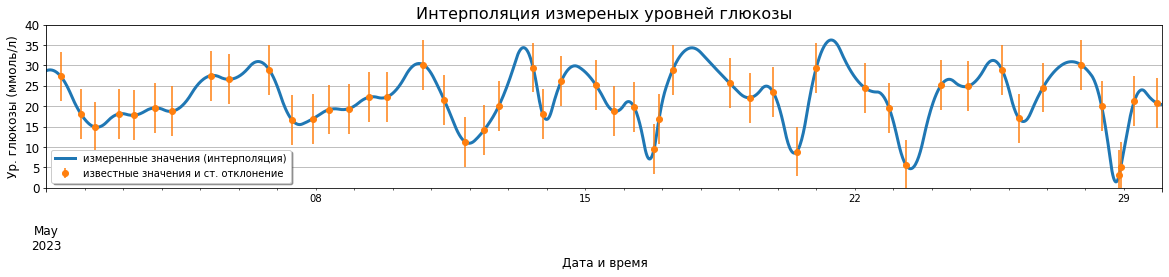

In [57]:
plt.figure(figsize=(20, 3))

data['glucose_level'].plot(grid=True, label='измеренные значения (интерполяция)', linewidth = 3)
data['glucose_level_true'].plot(grid=True, label='известные значения и ст. отклонение', yerr=yerr, fmt='o')
plt.legend(loc='best', fancybox = True, shadow = True)
plt.title(f'Интерполяция измереных уровней глюкозы', size = 16)
plt.xlabel('Дата и время', size = 12)
plt.ylabel('Ур. глюкозы (ммоль/л)', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylim([0, 40])
plt.xlim(['2023-05-01', '2023-05-30'])
plt.show()

Проверим корреляции между признаками, используемыми для построения модели

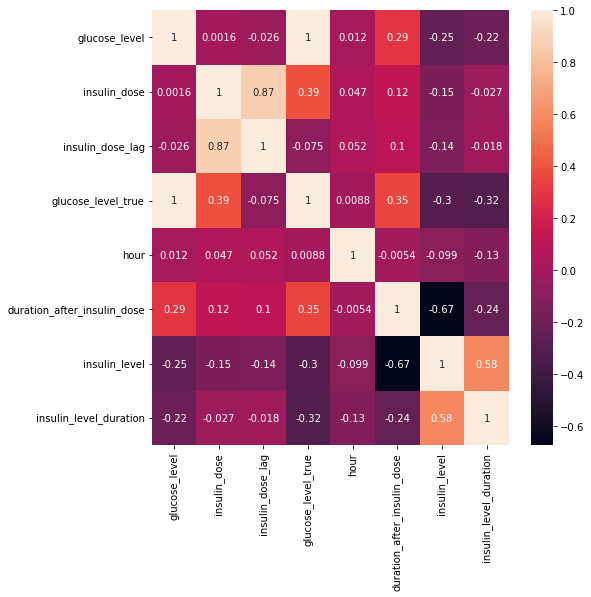

In [58]:
# Вычислим матрицу корреляций для data
corr_matrix = data.corr()

# Установим размер поля 8 на 8 дюймов
fig, ax = plt.subplots(figsize=(8, 8))

# Визуализируем матрицу корреляций в виде тепловой карты
heatmap = sns.heatmap(corr_matrix, annot=True, ax=ax)

plt.show()

Уровень глюкозы в крови имеет отрицательную корреляцию с содержанием инсулина в крови (-0.25), а также с произведением длительности после введения инсулина на содержание инсулина в крови (-0.22). Имеется положительная корреляция между длительностью после введения инсулина и уровнем глюкозы (0.29). Низкая отрицательная корреляция уровня глюкозы между insulin_dose (-0.027) и insulin_dose_lag (-0.018) связана с несбалансированностью данных в этих столбцах, которая возникает в следствии того, что в течении суток имеются (в среднем) лишь два отличных от нуля значения (инъекция инсулина утром и вечером), в остальное время значения в этих столбцах равны 0.

Построим график среденего уровня глюкозы в течении суток в будние и выхдные дни  

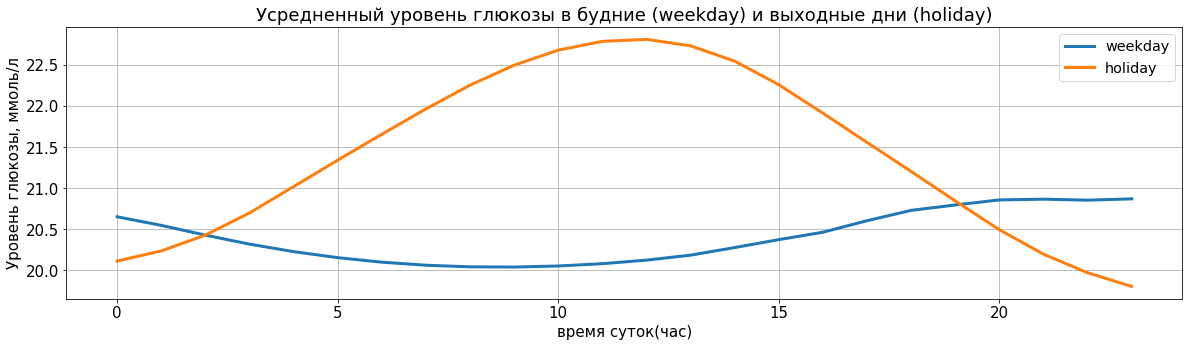

In [59]:
# Визуализируем значения среднего уровня глюкозы в будние и выходные дни. В случае отсутствия зависимости, создание столбца day является избыточным 
for day in list(data['day'].unique()):
    pd.pivot_table(data, index=data.index.hour, columns='day', values='glucose_level', aggfunc='mean')[day].plot(figsize=(20, 5), grid=True, linewidth = 3) 

plt.xlabel('время суток(час)', size = 15)
plt.ylabel('Уровень глюкозы, ммоль/л', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Усредненный уровень глюкозы в будние (weekday) и выходные дни (holiday)', size = 18)
plt.legend(loc='upper right', fontsize='x-large') 
    
plt.show()

На графике видны различия в уровне глюкозы в будние дни и нерабочие дни. В среднем уровень глюкозы в нерабочие дни немного выше, чем в будние, вероятнее всего это связано с различиями в образе жизни и режиме питания животного. Полученные результаты показывают важность выбора оптимального режима питания и контроля уровня глюкозы, особенно в те дни, когда показатели глюкозы могут быть выше средних значений

Для проверки стационарности временного ряда применим тест Дики-Фуллера 

In [60]:
# проверка ряда на стационарность с помощью теста Дики-Фулера
ts = data['glucose_level']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05: #Если значение с индексом 1 меньше P-Value (0.05), то ряд стационарный
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


Значение p-value меньше заданного уровня значимости ( 0.05), что позволяет отвергнуть нулевую гипотезу о нестационарности ряда. Это означает, что временной ряд можно считать стационарным.

Стационарность ряда важна для применения моделей прогнозирования, так как она предполагает, что статистические характеристики ряда будут сохраняться и в будущем

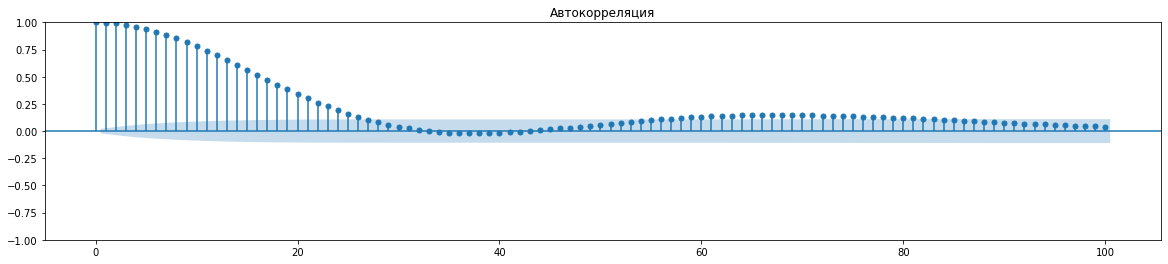

In [61]:
# посмотрим автокорреляции для значений уровня глюкозы
fig = tsaplots.plot_acf(data['glucose_level'], lags=100, title='Автокорреляция')
fig.set_size_inches(20, 4)
plt.show() 

Автокорреляция значительно отличается от нуля на первых 30 лагах, а затем снижается и становится отрицательной в интервале от 30 до 42 лага. После этого она снова становится положительной, но в значительно меньшей степени, что указывает на более слабую связь между значениями на более дальних временных отрезках. Таким образом, на автокорреляцию почти не оказывают воздействя уровни глюкозы, измеренные более 2-х дней назад.

**Построение модели**

Напишем функцию predict_glucose для предсказания целевого признака на n шагов вперед.

Функция принимает следующие аргументы:
df - датафрейм, содержащий данные для обучения и предсказания.
n - количество шагов прогноза.
lag - число лагов.
roll - размер окна скользящего среднего.

Описание работы функции:
1. В переменную target_true записываются последние n реальных значений уровня глюкозы из переданного датафрейма.
2. производится кодировка категориальных признаков.
3. Инициализируется модель с заданными параметрами.
4. Выполняется итерация для последних n строк датафрейма. В каждой итерации:
- создаются заданное аргументом lag число столбцов с лагами.
- вычисляется скользящее среднее и записывается в столбец rolling_mean.
- удаляются строки с пропущенными значениями, возникшими в результате вычисления лага и скользящего среднего.
- создаются признаки для обучения модели (features_train) и целевой признак (target_train).
- обучение модели.
- создаются признаки для предсказания (features_pred) из строки датафрейма следующей за последней строкой, использовавшейся для получения features_train.
- получаем значение целевого признака для следующего шага (target_pred).
- столбец glucose_level в датафрейме обновляется предсказанным значением.
6. По окончании цикла выбираются последние n предсказанных значений из столбца glucose_level и записываются в переменную target_predict.
5. Функция возвращает реальные значения глюкозы (target_true) и предсказанные значения глюкозы (target_predict).

В связи с небольшим размером выборки, используемые для прогнозирования уровня глюкозы модели, будут склонны к переобучению. Для устранения возможного переобучения в проекте используется Ridge регрессия (гребневая регрессия). В данной модели функция потерь является линейной функцией наименьших квадратов, а регуляризация задается L2-нормой. В применяемой модели константа alpha (которая умножает член L2, контролируя силу регуляризации) равна 1.5. Коэффициент alpha = 1.5 был определён путем подбора исходя из наименьшего полученного значения метрики.  Для сокращения времени на изучение и анализ данного проекта подбор оптимального коэффициента alpha не приводится. Выбор Ridge регрессии также был обусловлен наличием признаков, которые не являются независимыми друг от друга (коллинеарность).

In [62]:
def predict_glucose(df, n, lag, roll):
    
    # для проверки качества модели запишем последние n значений в target_true
    target_true = df['glucose_level'][-n:]

    # кодировка категориальных признаков 
    df = pd.get_dummies(df, columns=['hour', 'day', 'dayofweek'], drop_first= True)

    # создадим модель
    model = Ridge(alpha=1.5, random_state= SEED)
        
    for i in range(n, 0, -1):

        # создаем столбцы с лагами
        for j in range(1, lag):
            df[f'lag_{j}'] = df['glucose_level'].shift(j)

        # создаём столбец со скользящим средним    
        df['rolling_mean'] = df['glucose_level'].shift().rolling(roll).mean()

        # убираем пропуски
        df = df[lag:]

        # создаем признаки для обучения модели
        features_train = df[:-i-1].drop(['glucose_level', 'glucose_level_true'] , axis=1)
        
        # создаём целевые признаки
        target_train = df['glucose_level'][:-i-1]

        # обучаем модель
        model.fit(features_train, target_train)

        # создаём признаки для предсказания значения на следующем шаге
        features_pred = df.drop(['glucose_level', 'glucose_level_true'], axis=1).iloc[-i].values.reshape(1, -1)
        
        # получаем предсказание на следующем шаге
        target_pred = model.predict(features_pred)

        # записываем предсказаное значение в df            
        df['glucose_level'].iloc[-i] = round(float(target_pred[0]), 2)

    # предсказания модели для n шагов
    target_predict = df['glucose_level'][-n:]
          
    return target_true, target_predict

Создадим функцию plotting_predict, которая выполняет визуализацию прогнозируемых значений и измеренных значений уровня глюкозы.

Описание работы функции:
1. Создание графического окна размером 18 на 3 дюйма.
2. Построение графика измеренных значений уровня глюкозы (target_true).
3. Построение графика предсказанных значений уровня глюкозы (target_predict).
4. Визуализация известных (измеренных) значений уровня глюкозы и стандартного отклонения. Стандартное отклонение показывается в виде вертикальных линий вокруг точек.
5. Задание параметров графика (заголовок, подписи осей, размер шрифта и ограничения по значениям).
6. Функция возвращает объект plt, для дальнейшего его использования.


In [63]:
def plotting_predict(target_true, target_predict):
    plt.figure(figsize=(18, 3))

    target_true.plot(grid=True, label='измеренные значения (интерполяция)', linewidth = 3)
    target_predict.plot(grid=True, label='предсказания модели', linewidth = 3, linestyle='dashed')
    data['glucose_level_true'].plot(grid=True, label='известные значения и ст. отклонение', yerr=yerr, fmt='o')

    plt.legend(loc='best', fancybox = True, shadow = True)
    plt.title(f'Прогноз уровня глюкозы на {N} ч. (с {target_predict.index.min()} по {target_predict.index.max()})', size = 16)
    plt.xlabel('Дата и время', size = 12)
    plt.ylabel('Ур. глюкозы (ммоль/л)', size = 12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.ylim([3, 35])
    plt.xlim([target_predict.index.min(), target_predict.index.max()])
    plt.show()
    
    return plt

Реализуем проверку качества прогноза модели с помощью кросс-валидации. Кросс-валидацию выполним с использованием цикла while. В цикле выведем графики с имеющимися значениями уровня глюкозы (интерполяция и истинные значения) и со значениями предсказанными моделью. Под графиками разместим информацию о МАЕ на интервале и средним значением МАЕ по выполненным итерациям. После каждой итерации из данных удаляются последние N часов (для которых строился прогноз уровня глюкозы - горизонт прогноза), далее прогноз осуществляется для следующих 24 часов и так пока размер датасета не станет менее MIN_ROW строк

In [64]:
def cv_plot(df, N, LAG, ROLLING, MIN_ROW):
    mae_mean = []

    while len(df) >= MIN_ROW:
        target_true, target_predict = predict_glucose(df, N*2, LAG, ROLLING)
        
        plot = plotting_predict(target_true, target_predict)
        plot.show()

        mae_model = round(mean_absolute_error(target_true, target_predict), 2)
        mae_mean.append(mae_model)

        df = df.iloc[:-N*2]

        print(f'MAE для интервала с {target_predict.index.min()} по {target_predict.index.max()} составило {mae_model} ммоль/л.',
              f'Среднее MAE по выполненным итерациям: {round(np.mean(mae_mean), 2)} ммоль/л')

    return mae_mean

**Проверка модели на 24 часовом интервале прогнозирования**

In [65]:
# установим горизонт прогноза равным 24 часам
N = 24

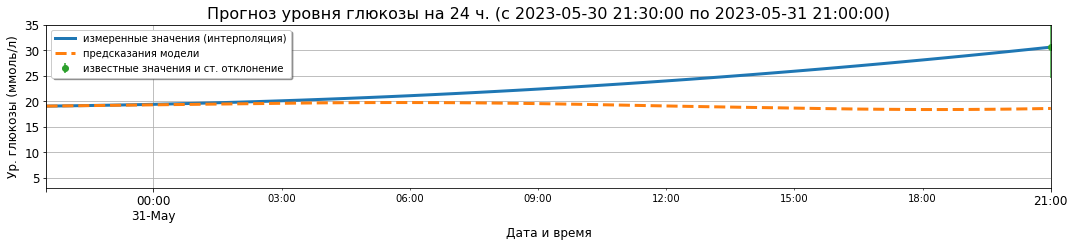

MAE для интервала с 2023-05-30 21:30:00 по 2023-05-31 21:00:00 составило 4.19 ммоль/л. Среднее MAE по выполненным итерациям: 4.19 ммоль/л


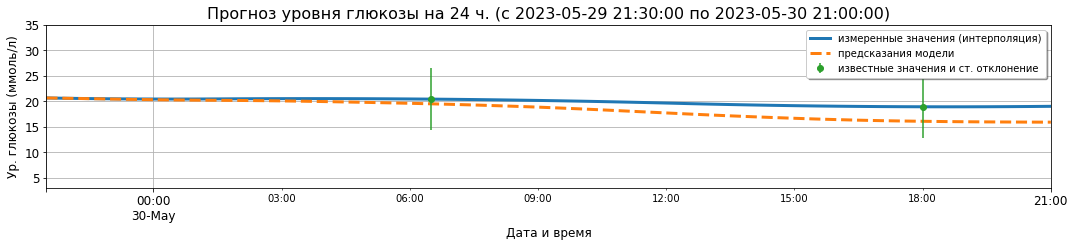

MAE для интервала с 2023-05-29 21:30:00 по 2023-05-30 21:00:00 составило 1.47 ммоль/л. Среднее MAE по выполненным итерациям: 2.83 ммоль/л


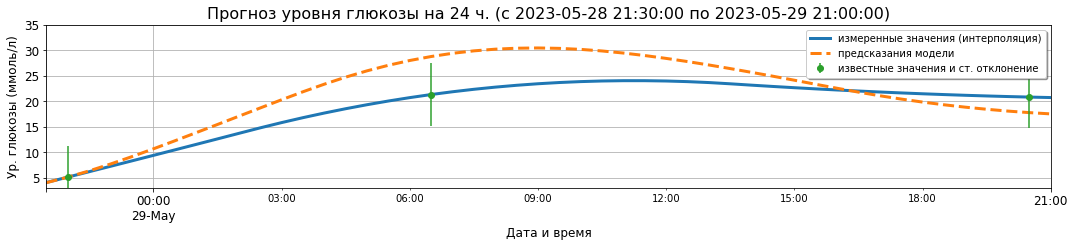

MAE для интервала с 2023-05-28 21:30:00 по 2023-05-29 21:00:00 составило 3.64 ммоль/л. Среднее MAE по выполненным итерациям: 3.1 ммоль/л


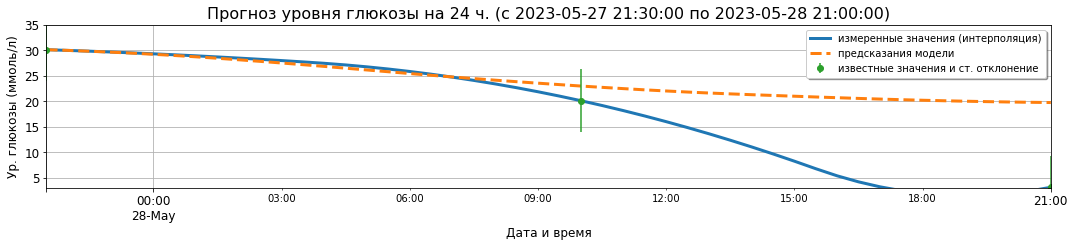

MAE для интервала с 2023-05-27 21:30:00 по 2023-05-28 21:00:00 составило 6.23 ммоль/л. Среднее MAE по выполненным итерациям: 3.88 ммоль/л


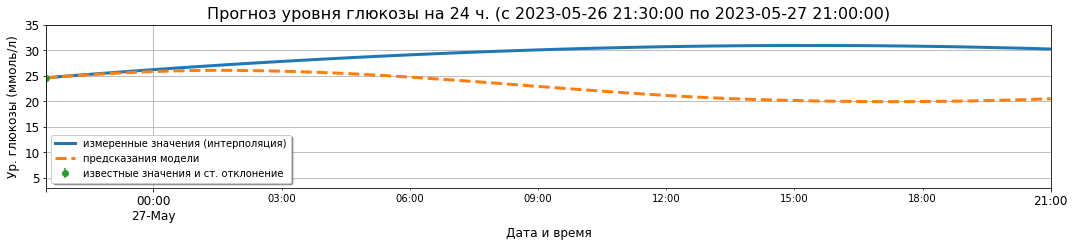

MAE для интервала с 2023-05-26 21:30:00 по 2023-05-27 21:00:00 составило 6.36 ммоль/л. Среднее MAE по выполненным итерациям: 4.38 ммоль/л


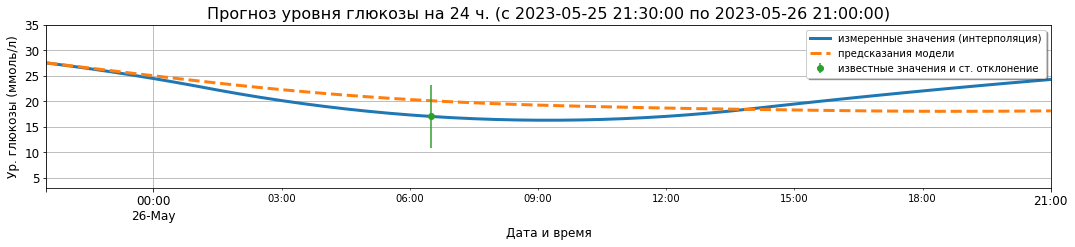

MAE для интервала с 2023-05-25 21:30:00 по 2023-05-26 21:00:00 составило 2.34 ммоль/л. Среднее MAE по выполненным итерациям: 4.04 ммоль/л


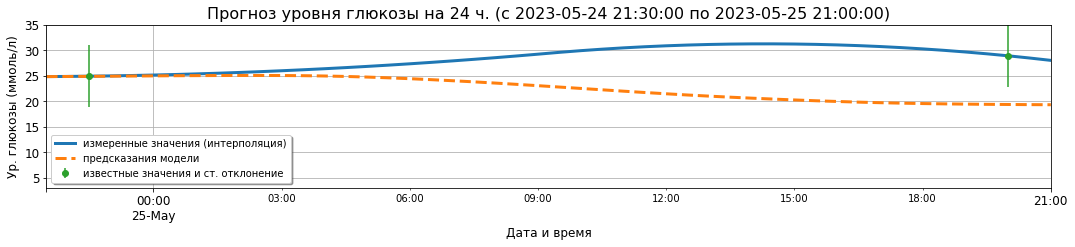

MAE для интервала с 2023-05-24 21:30:00 по 2023-05-25 21:00:00 составило 5.83 ммоль/л. Среднее MAE по выполненным итерациям: 4.29 ммоль/л


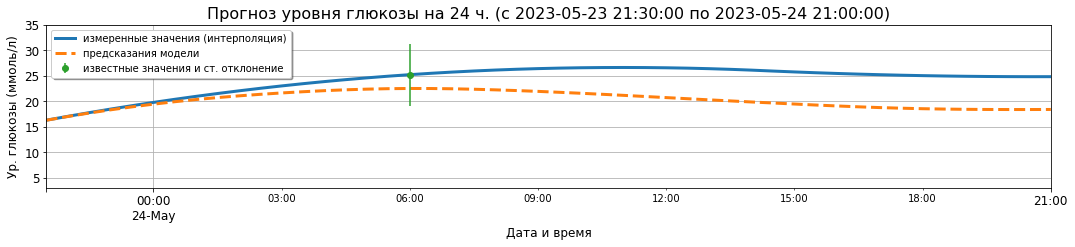

MAE для интервала с 2023-05-23 21:30:00 по 2023-05-24 21:00:00 составило 3.91 ммоль/л. Среднее MAE по выполненным итерациям: 4.25 ммоль/л


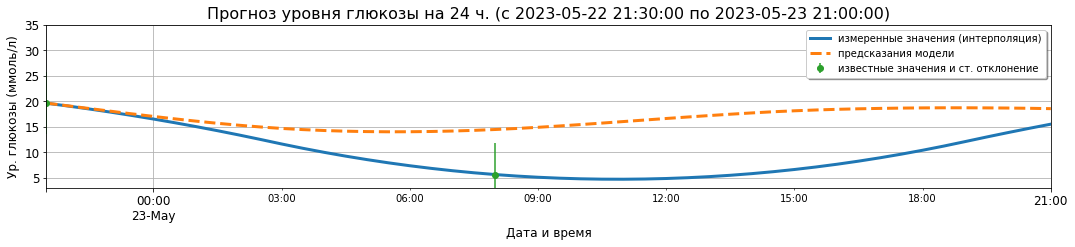

MAE для интервала с 2023-05-22 21:30:00 по 2023-05-23 21:00:00 составило 6.72 ммоль/л. Среднее MAE по выполненным итерациям: 4.52 ммоль/л


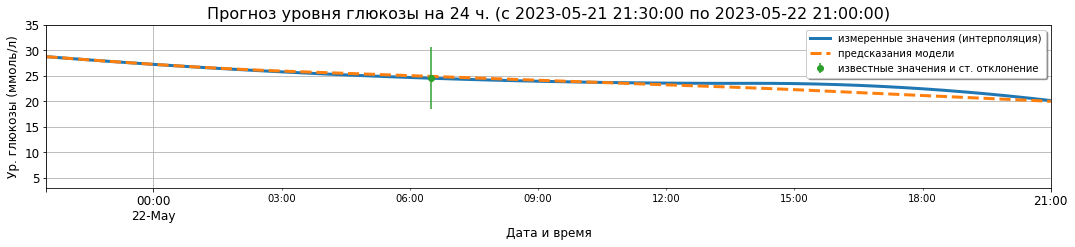

MAE для интервала с 2023-05-21 21:30:00 по 2023-05-22 21:00:00 составило 0.47 ммоль/л. Среднее MAE по выполненным итерациям: 4.12 ммоль/л


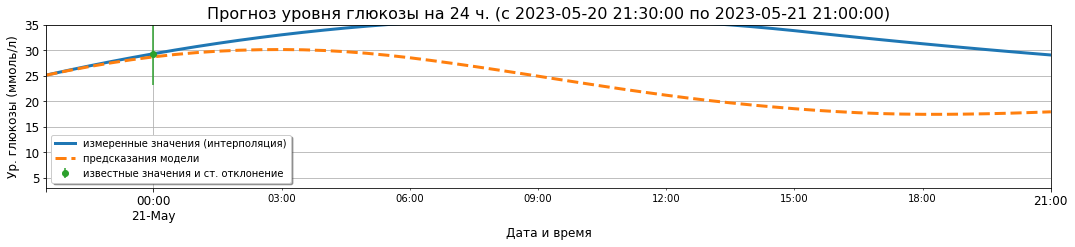

MAE для интервала с 2023-05-20 21:30:00 по 2023-05-21 21:00:00 составило 9.01 ммоль/л. Среднее MAE по выполненным итерациям: 4.56 ммоль/л


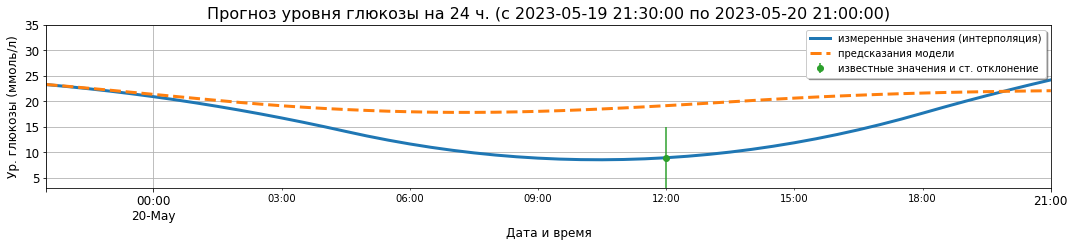

MAE для интервала с 2023-05-19 21:30:00 по 2023-05-20 21:00:00 составило 5.21 ммоль/л. Среднее MAE по выполненным итерациям: 4.61 ммоль/л


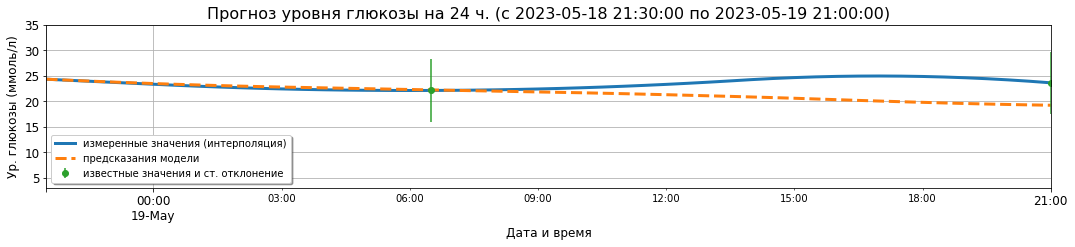

MAE для интервала с 2023-05-18 21:30:00 по 2023-05-19 21:00:00 составило 1.89 ммоль/л. Среднее MAE по выполненным итерациям: 4.41 ммоль/л


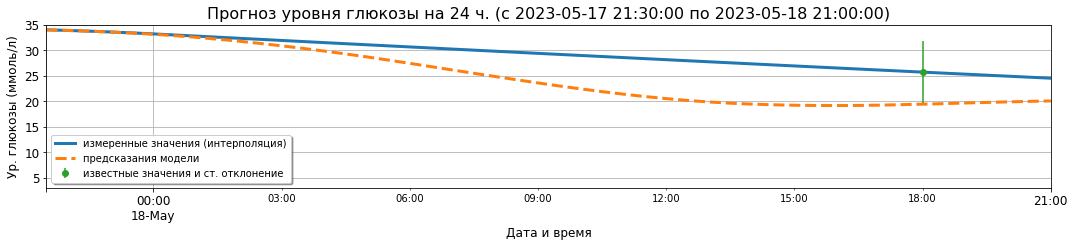

MAE для интервала с 2023-05-17 21:30:00 по 2023-05-18 21:00:00 составило 4.32 ммоль/л. Среднее MAE по выполненным итерациям: 4.4 ммоль/л


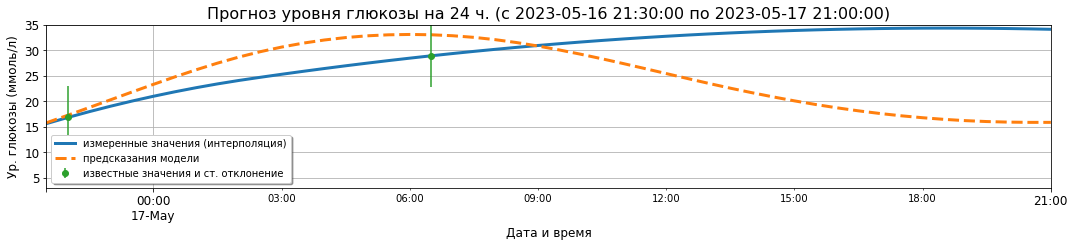

MAE для интервала с 2023-05-16 21:30:00 по 2023-05-17 21:00:00 составило 7.86 ммоль/л. Среднее MAE по выполненным итерациям: 4.63 ммоль/л


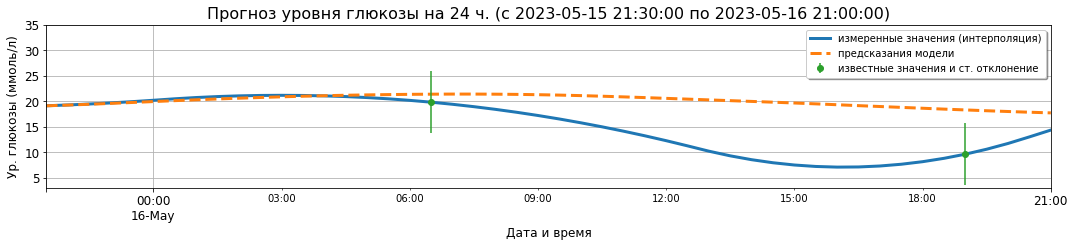

MAE для интервала с 2023-05-15 21:30:00 по 2023-05-16 21:00:00 составило 4.94 ммоль/л. Среднее MAE по выполненным итерациям: 4.65 ммоль/л


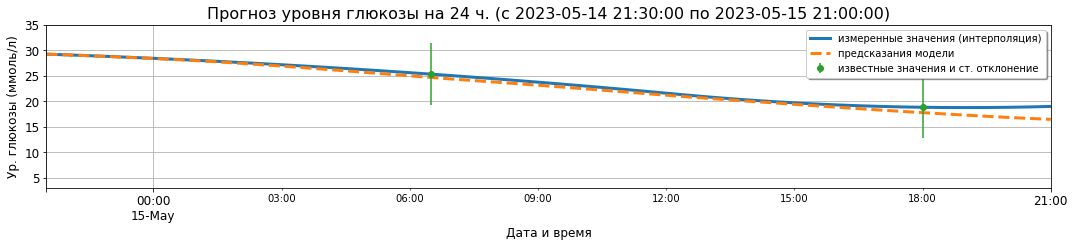

MAE для интервала с 2023-05-14 21:30:00 по 2023-05-15 21:00:00 составило 0.57 ммоль/л. Среднее MAE по выполненным итерациям: 4.41 ммоль/л


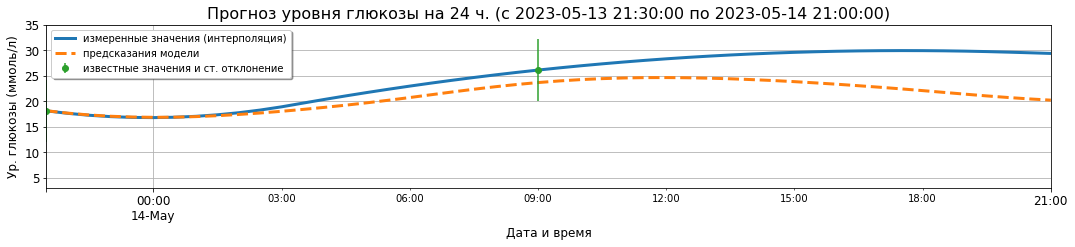

MAE для интервала с 2023-05-13 21:30:00 по 2023-05-14 21:00:00 составило 3.53 ммоль/л. Среднее MAE по выполненным итерациям: 4.36 ммоль/л


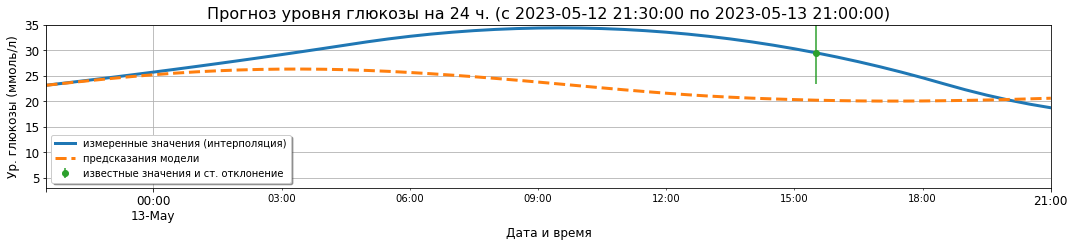

MAE для интервала с 2023-05-12 21:30:00 по 2023-05-13 21:00:00 составило 5.97 ммоль/л. Среднее MAE по выполненным итерациям: 4.45 ммоль/л


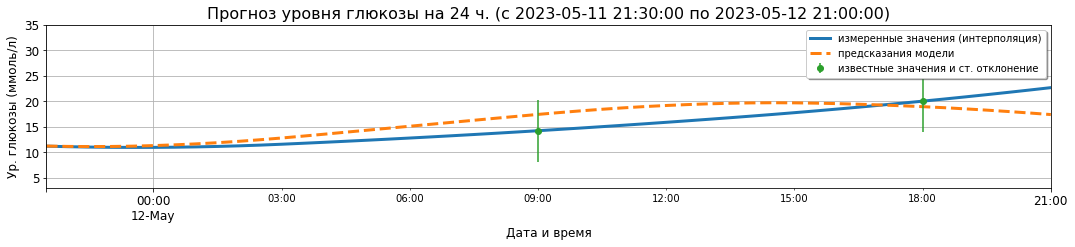

MAE для интервала с 2023-05-11 21:30:00 по 2023-05-12 21:00:00 составило 1.99 ммоль/л. Среднее MAE по выполненным итерациям: 4.32 ммоль/л


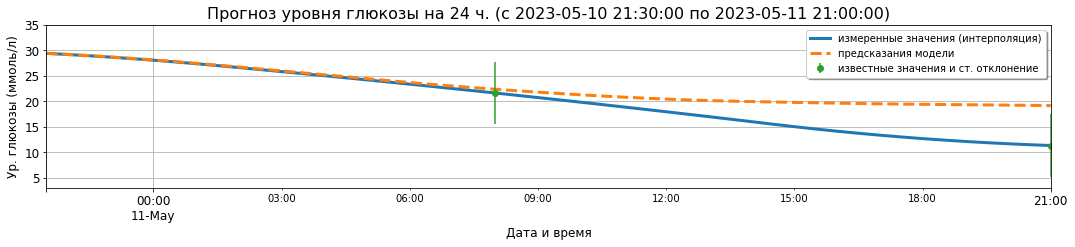

MAE для интервала с 2023-05-10 21:30:00 по 2023-05-11 21:00:00 составило 2.51 ммоль/л. Среднее MAE по выполненным итерациям: 4.24 ммоль/л


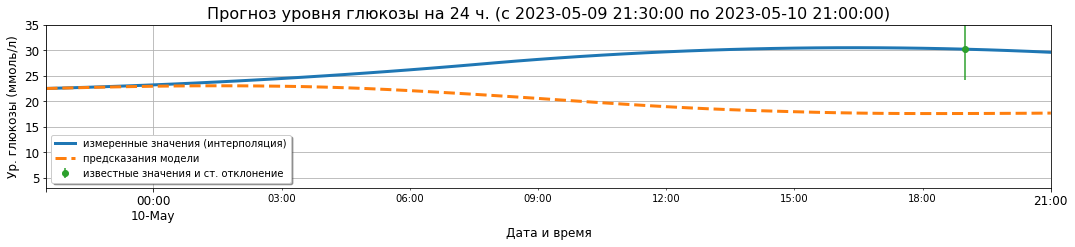

MAE для интервала с 2023-05-09 21:30:00 по 2023-05-10 21:00:00 составило 7.08 ммоль/л. Среднее MAE по выполненным итерациям: 4.37 ммоль/л


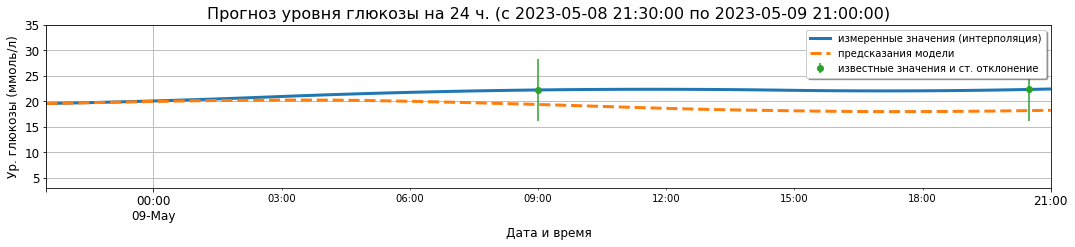

MAE для интервала с 2023-05-08 21:30:00 по 2023-05-09 21:00:00 составило 2.46 ммоль/л. Среднее MAE по выполненным итерациям: 4.28 ммоль/л


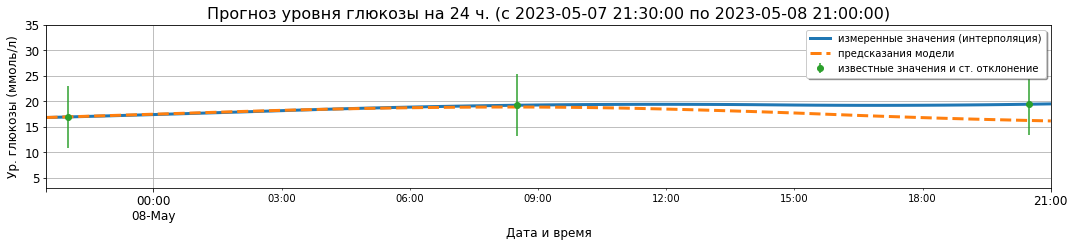

MAE для интервала с 2023-05-07 21:30:00 по 2023-05-08 21:00:00 составило 0.93 ммоль/л. Среднее MAE по выполненным итерациям: 4.14 ммоль/л


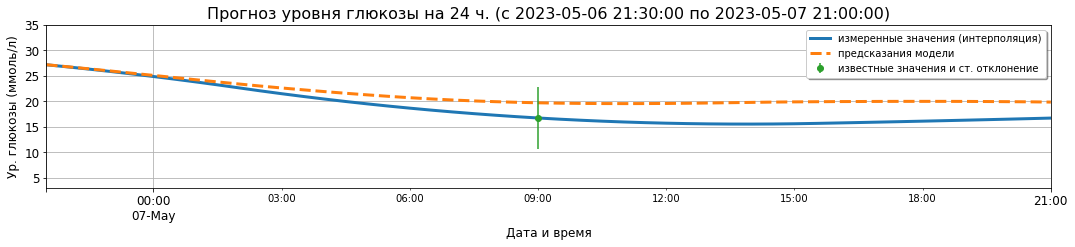

MAE для интервала с 2023-05-06 21:30:00 по 2023-05-07 21:00:00 составило 2.54 ммоль/л. Среднее MAE по выполненным итерациям: 4.08 ммоль/л


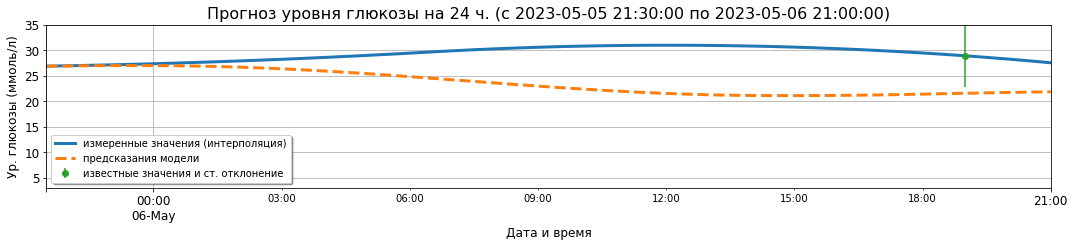

MAE для интервала с 2023-05-05 21:30:00 по 2023-05-06 21:00:00 составило 5.63 ммоль/л. Среднее MAE по выполненным итерациям: 4.14 ммоль/л


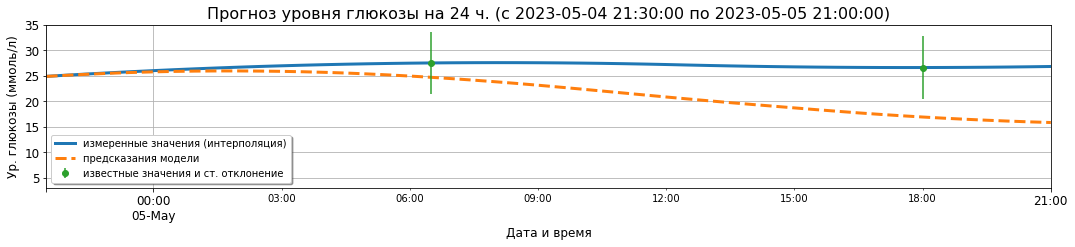

MAE для интервала с 2023-05-04 21:30:00 по 2023-05-05 21:00:00 составило 4.84 ммоль/л. Среднее MAE по выполненным итерациям: 4.16 ммоль/л


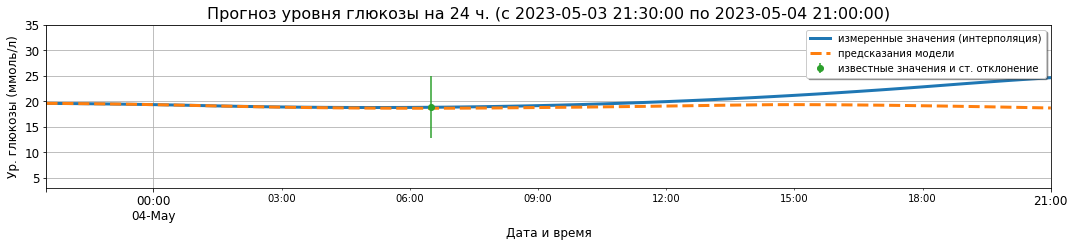

MAE для интервала с 2023-05-03 21:30:00 по 2023-05-04 21:00:00 составило 1.29 ммоль/л. Среднее MAE по выполненным итерациям: 4.06 ммоль/л


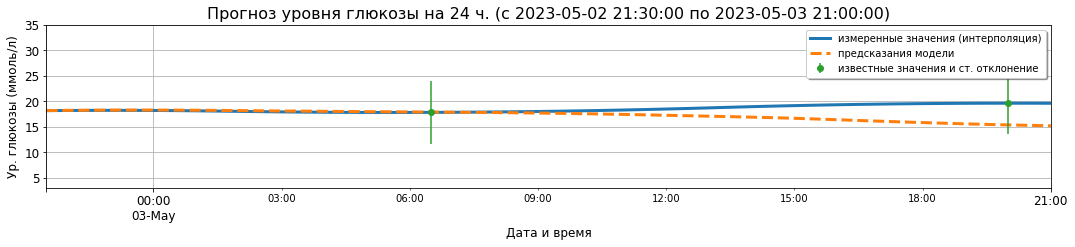

MAE для интервала с 2023-05-02 21:30:00 по 2023-05-03 21:00:00 составило 1.33 ммоль/л. Среднее MAE по выполненным итерациям: 3.97 ммоль/л


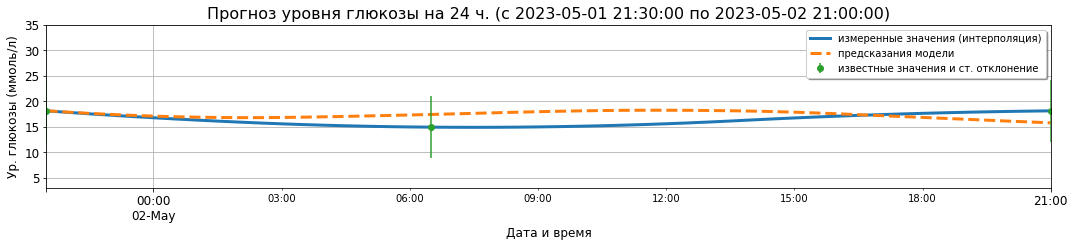

MAE для интервала с 2023-05-01 21:30:00 по 2023-05-02 21:00:00 составило 1.58 ммоль/л. Среднее MAE по выполненным итерациям: 3.89 ммоль/л


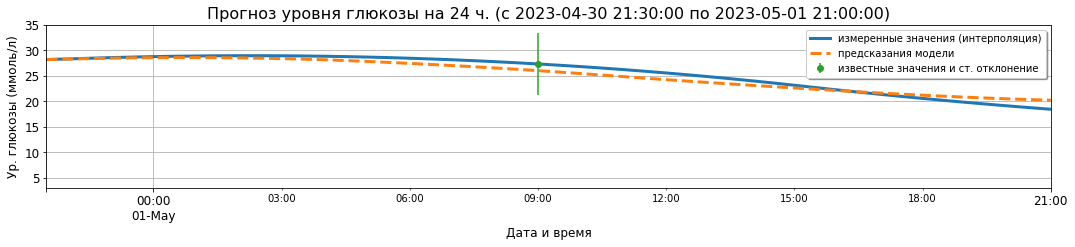

MAE для интервала с 2023-04-30 21:30:00 по 2023-05-01 21:00:00 составило 0.8 ммоль/л. Среднее MAE по выполненным итерациям: 3.79 ммоль/л


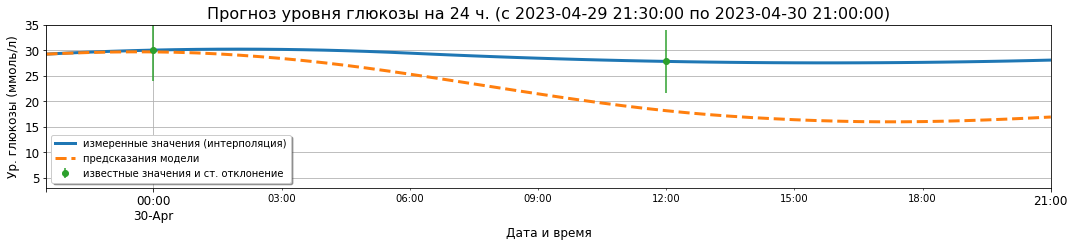

MAE для интервала с 2023-04-29 21:30:00 по 2023-04-30 21:00:00 составило 6.53 ммоль/л. Среднее MAE по выполненным итерациям: 3.87 ммоль/л


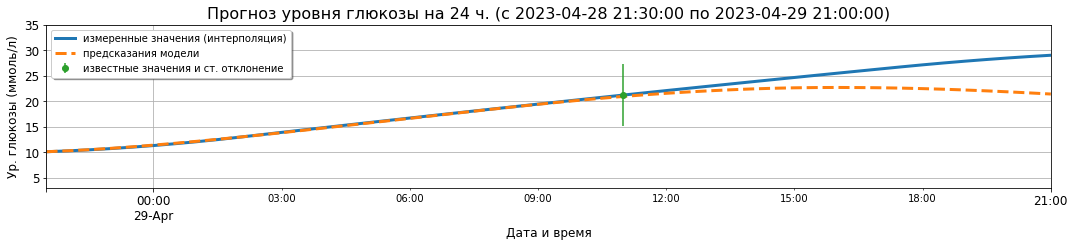

MAE для интервала с 2023-04-28 21:30:00 по 2023-04-29 21:00:00 составило 1.46 ммоль/л. Среднее MAE по выполненным итерациям: 3.8 ммоль/л


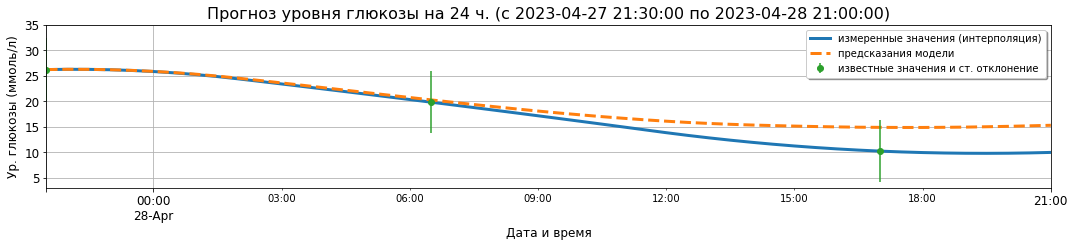

MAE для интервала с 2023-04-27 21:30:00 по 2023-04-28 21:00:00 составило 1.97 ммоль/л. Среднее MAE по выполненным итерациям: 3.75 ммоль/л


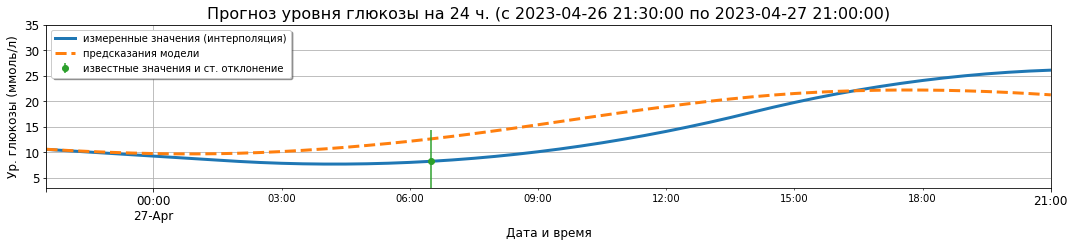

MAE для интервала с 2023-04-26 21:30:00 по 2023-04-27 21:00:00 составило 2.89 ммоль/л. Среднее MAE по выполненным итерациям: 3.72 ммоль/л


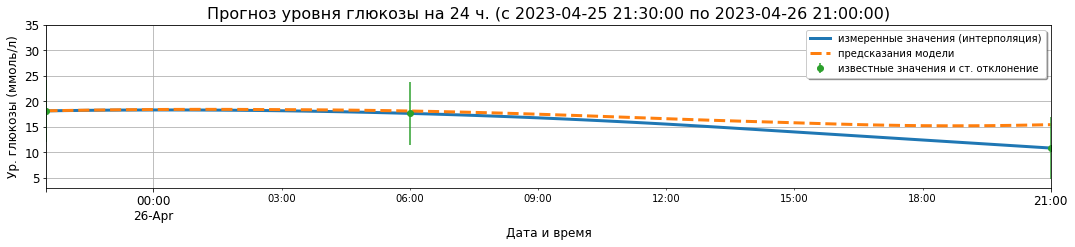

MAE для интервала с 2023-04-25 21:30:00 по 2023-04-26 21:00:00 составило 1.21 ммоль/л. Среднее MAE по выполненным итерациям: 3.65 ммоль/л


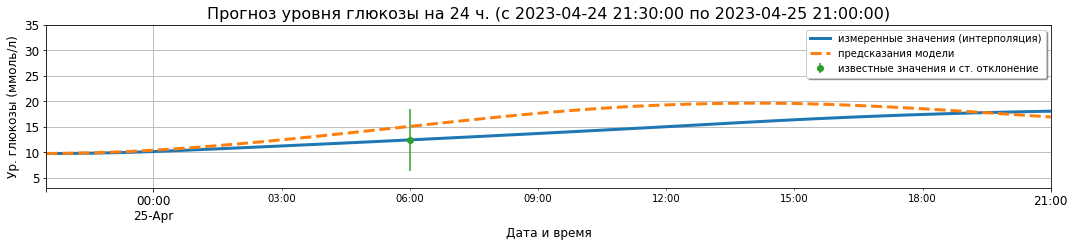

MAE для интервала с 2023-04-24 21:30:00 по 2023-04-25 21:00:00 составило 2.12 ммоль/л. Среднее MAE по выполненным итерациям: 3.61 ммоль/л


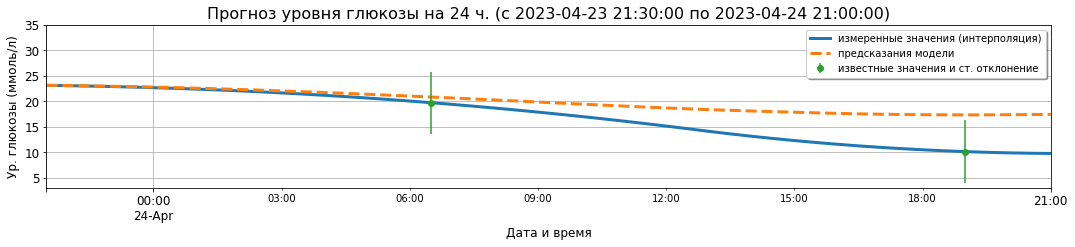

MAE для интервала с 2023-04-23 21:30:00 по 2023-04-24 21:00:00 составило 2.99 ммоль/л. Среднее MAE по выполненным итерациям: 3.6 ммоль/л


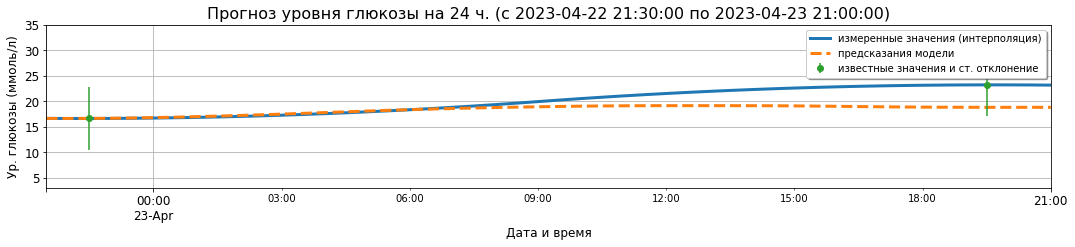

MAE для интервала с 2023-04-22 21:30:00 по 2023-04-23 21:00:00 составило 1.77 ммоль/л. Среднее MAE по выполненным итерациям: 3.55 ммоль/л


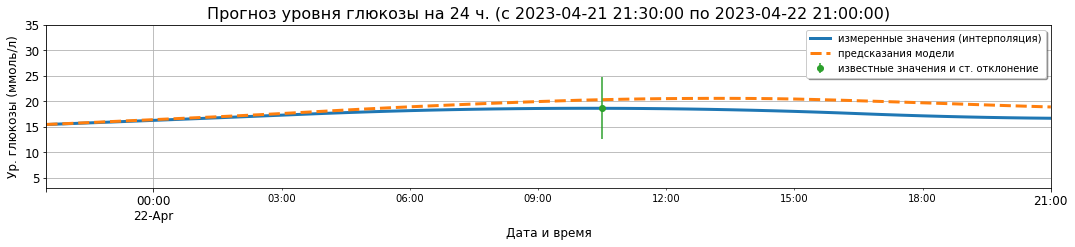

MAE для интервала с 2023-04-21 21:30:00 по 2023-04-22 21:00:00 составило 1.36 ммоль/л. Среднее MAE по выполненным итерациям: 3.49 ммоль/л


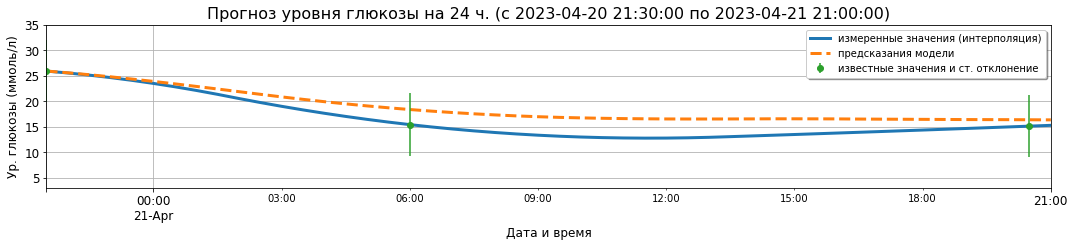

MAE для интервала с 2023-04-20 21:30:00 по 2023-04-21 21:00:00 составило 2.31 ммоль/л. Среднее MAE по выполненным итерациям: 3.46 ммоль/л


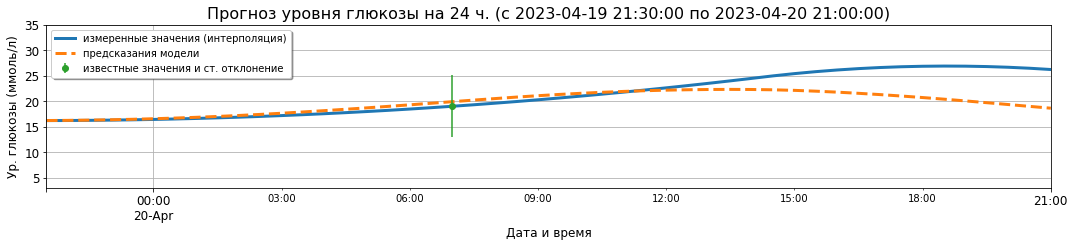

MAE для интервала с 2023-04-19 21:30:00 по 2023-04-20 21:00:00 составило 2.06 ммоль/л. Среднее MAE по выполненным итерациям: 3.43 ммоль/л


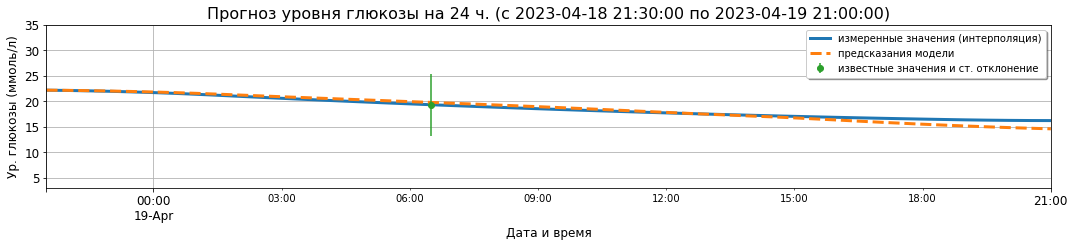

MAE для интервала с 2023-04-18 21:30:00 по 2023-04-19 21:00:00 составило 0.45 ммоль/л. Среднее MAE по выполненным итерациям: 3.36 ммоль/л


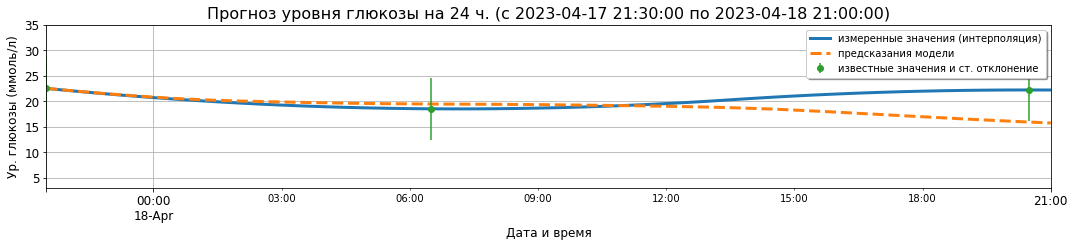

MAE для интервала с 2023-04-17 21:30:00 по 2023-04-18 21:00:00 составило 1.78 ммоль/л. Среднее MAE по выполненным итерациям: 3.33 ммоль/л


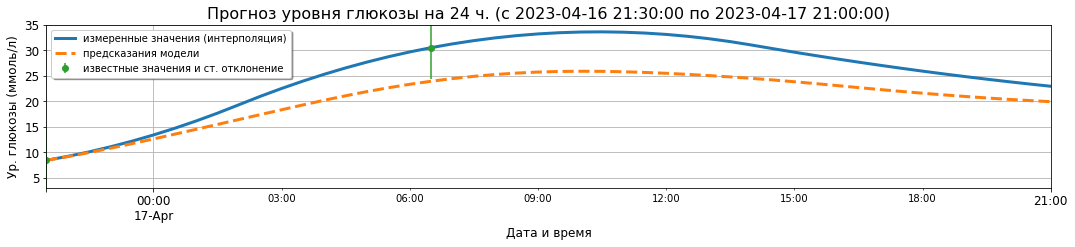

MAE для интервала с 2023-04-16 21:30:00 по 2023-04-17 21:00:00 составило 4.8 ммоль/л. Среднее MAE по выполненным итерациям: 3.36 ммоль/л


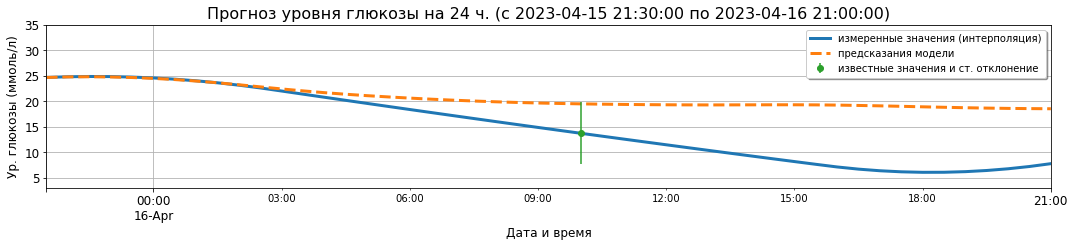

MAE для интервала с 2023-04-15 21:30:00 по 2023-04-16 21:00:00 составило 5.74 ммоль/л. Среднее MAE по выполненным итерациям: 3.41 ммоль/л


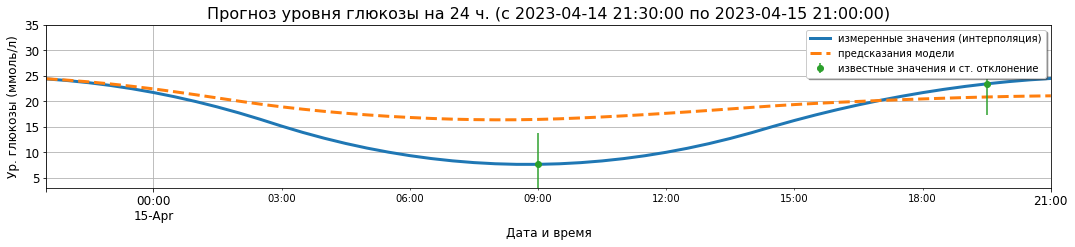

MAE для интервала с 2023-04-14 21:30:00 по 2023-04-15 21:00:00 составило 4.3 ммоль/л. Среднее MAE по выполненным итерациям: 3.43 ммоль/л


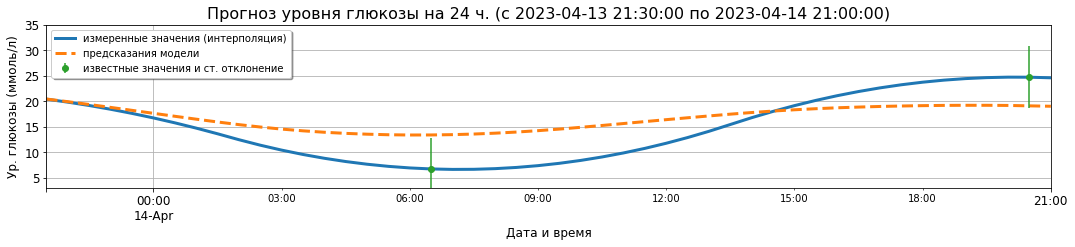

MAE для интервала с 2023-04-13 21:30:00 по 2023-04-14 21:00:00 составило 3.98 ммоль/л. Среднее MAE по выполненным итерациям: 3.44 ммоль/л


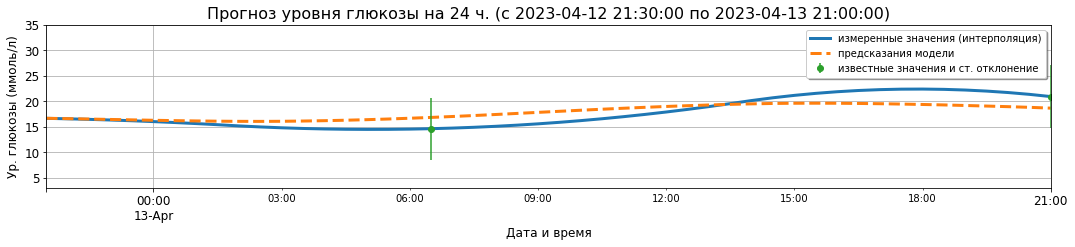

MAE для интервала с 2023-04-12 21:30:00 по 2023-04-13 21:00:00 составило 1.6 ммоль/л. Среднее MAE по выполненным итерациям: 3.4 ммоль/л


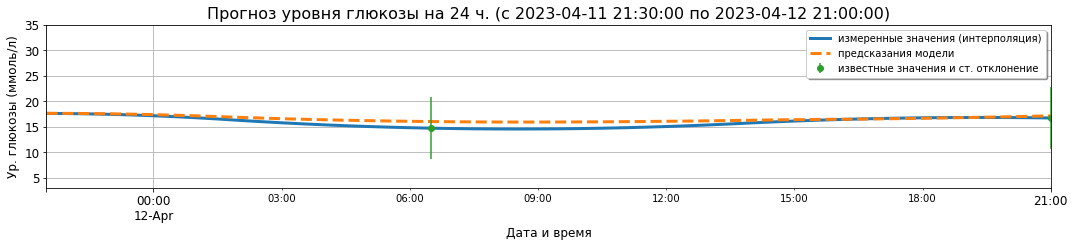

MAE для интервала с 2023-04-11 21:30:00 по 2023-04-12 21:00:00 составило 0.64 ммоль/л. Среднее MAE по выполненным итерациям: 3.35 ммоль/л


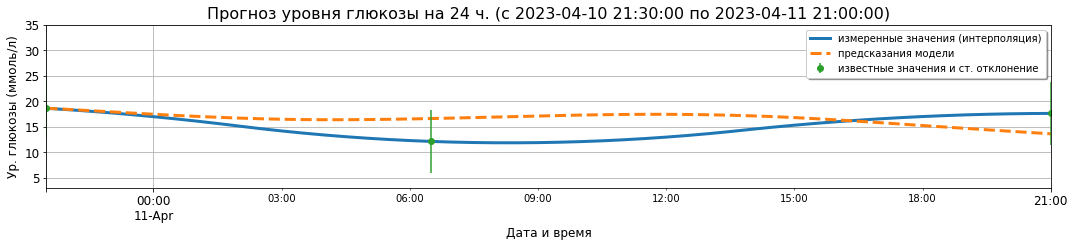

MAE для интервала с 2023-04-10 21:30:00 по 2023-04-11 21:00:00 составило 2.74 ммоль/л. Среднее MAE по выполненным итерациям: 3.34 ммоль/л


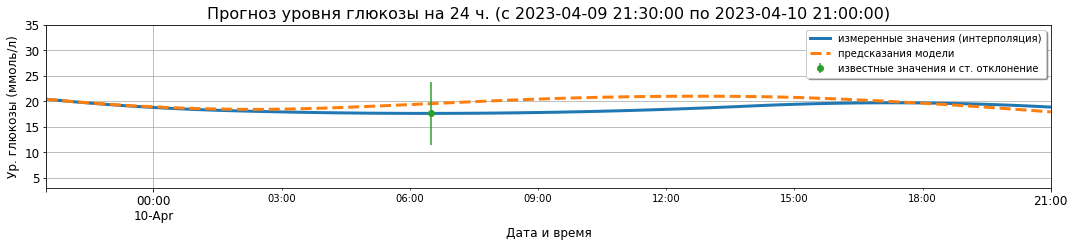

MAE для интервала с 2023-04-09 21:30:00 по 2023-04-10 21:00:00 составило 1.21 ммоль/л. Среднее MAE по выполненным итерациям: 3.3 ммоль/л


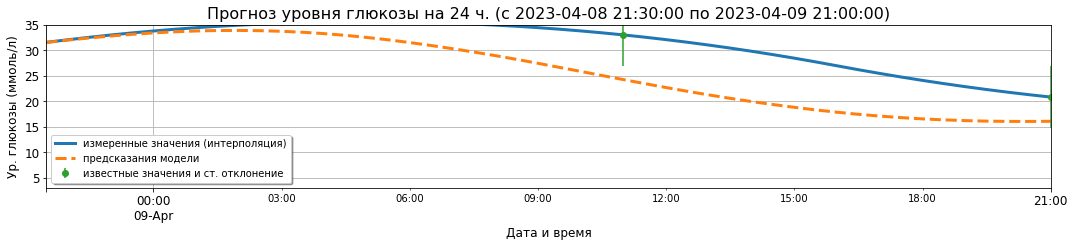

MAE для интервала с 2023-04-08 21:30:00 по 2023-04-09 21:00:00 составило 5.32 ммоль/л. Среднее MAE по выполненным итерациям: 3.33 ммоль/л


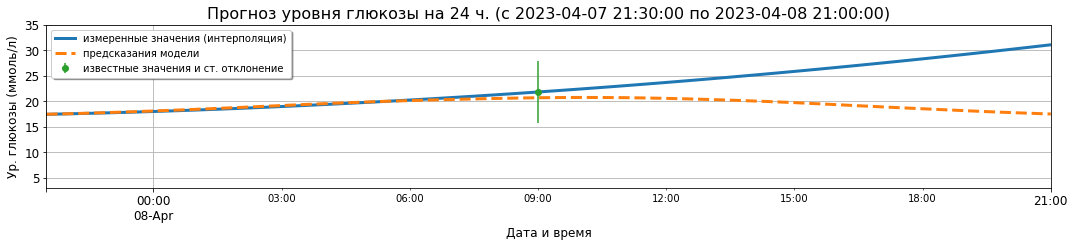

MAE для интервала с 2023-04-07 21:30:00 по 2023-04-08 21:00:00 составило 3.53 ммоль/л. Среднее MAE по выполненным итерациям: 3.34 ммоль/л


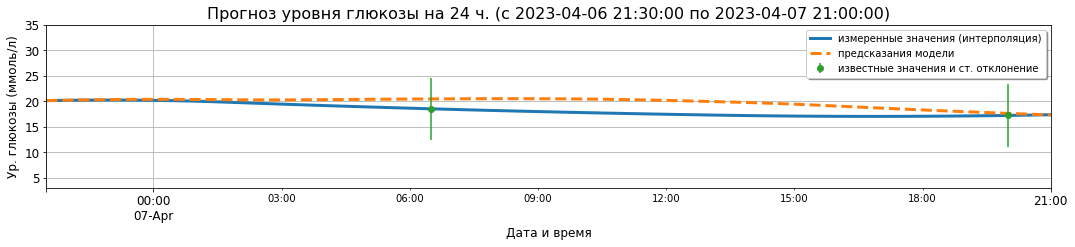

MAE для интервала с 2023-04-06 21:30:00 по 2023-04-07 21:00:00 составило 1.47 ммоль/л. Среднее MAE по выполненным итерациям: 3.3 ммоль/л


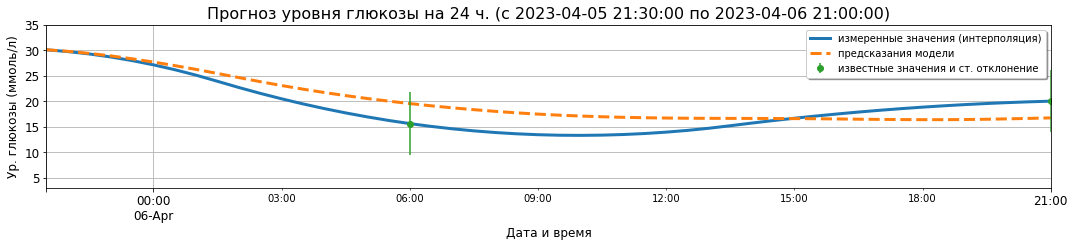

MAE для интервала с 2023-04-05 21:30:00 по 2023-04-06 21:00:00 составило 2.34 ммоль/л. Среднее MAE по выполненным итерациям: 3.29 ммоль/л


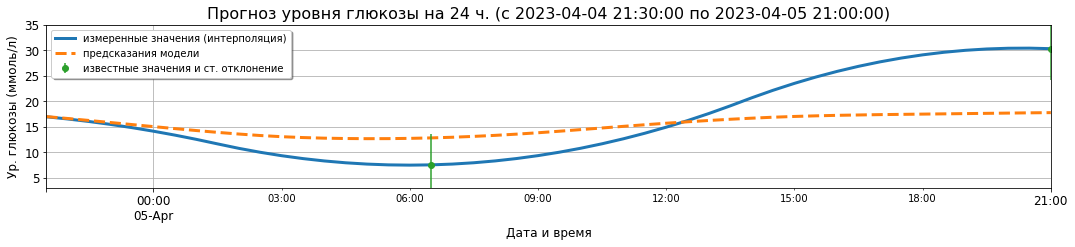

MAE для интервала с 2023-04-04 21:30:00 по 2023-04-05 21:00:00 составило 5.12 ммоль/л. Среднее MAE по выполненным итерациям: 3.32 ммоль/л


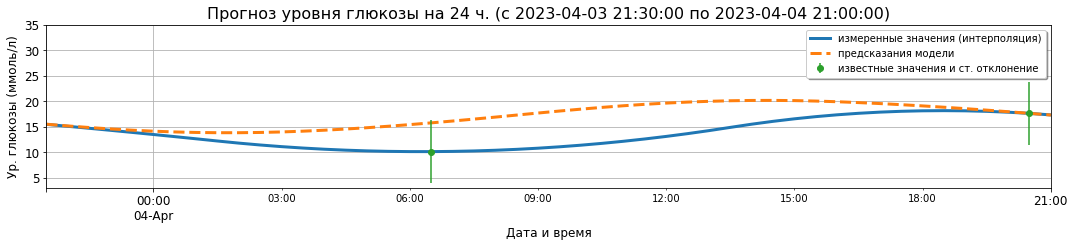

MAE для интервала с 2023-04-03 21:30:00 по 2023-04-04 21:00:00 составило 3.35 ммоль/л. Среднее MAE по выполненным итерациям: 3.32 ммоль/л


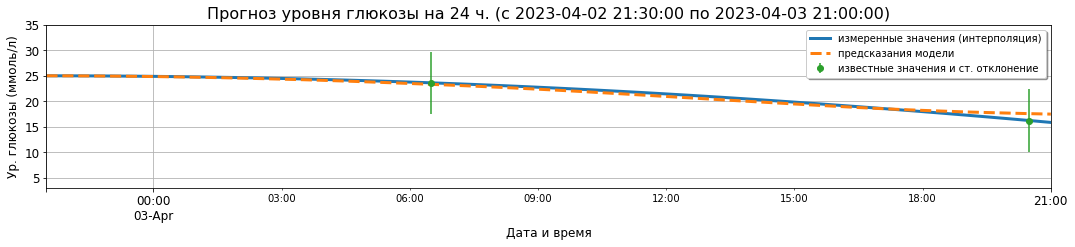

MAE для интервала с 2023-04-02 21:30:00 по 2023-04-03 21:00:00 составило 0.34 ммоль/л. Среднее MAE по выполненным итерациям: 3.27 ммоль/л


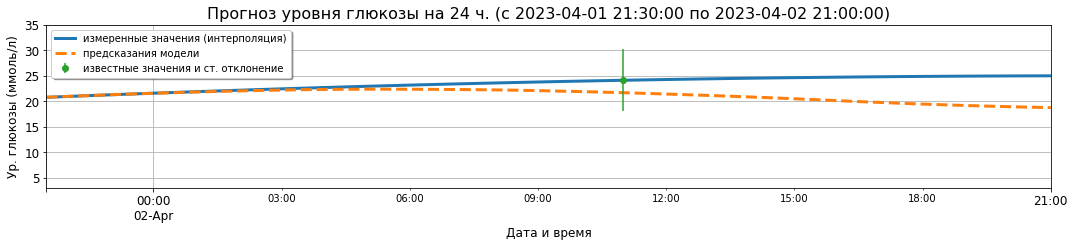

MAE для интервала с 2023-04-01 21:30:00 по 2023-04-02 21:00:00 составило 2.35 ммоль/л. Среднее MAE по выполненным итерациям: 3.25 ммоль/л


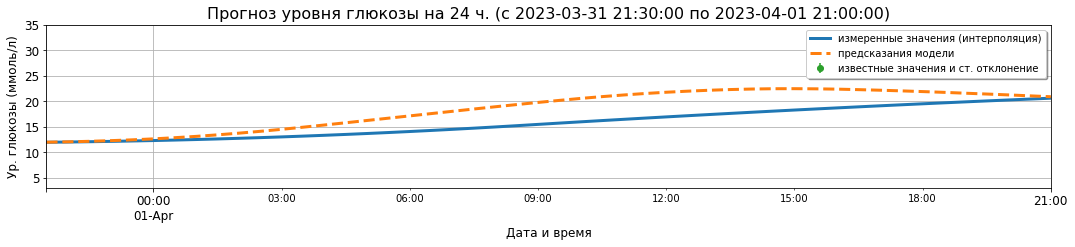

MAE для интервала с 2023-03-31 21:30:00 по 2023-04-01 21:00:00 составило 2.62 ммоль/л. Среднее MAE по выполненным итерациям: 3.24 ммоль/л


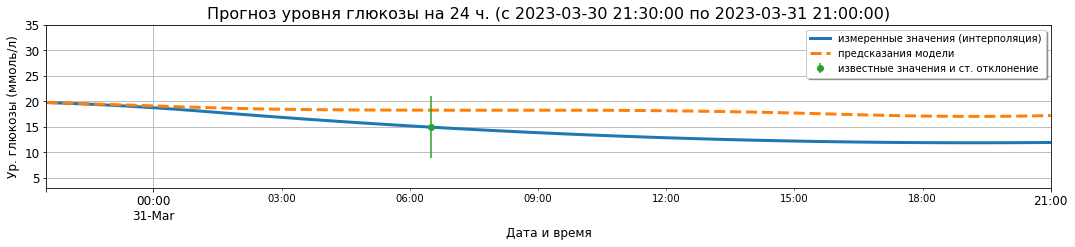

MAE для интервала с 2023-03-30 21:30:00 по 2023-03-31 21:00:00 составило 3.56 ммоль/л. Среднее MAE по выполненным итерациям: 3.25 ммоль/л


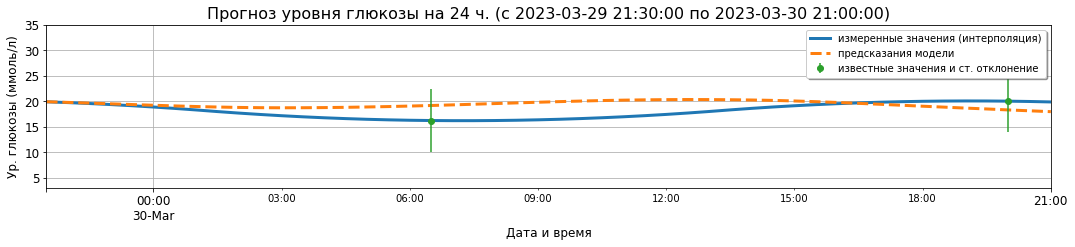

MAE для интервала с 2023-03-29 21:30:00 по 2023-03-30 21:00:00 составило 1.73 ммоль/л. Среднее MAE по выполненным итерациям: 3.22 ммоль/л


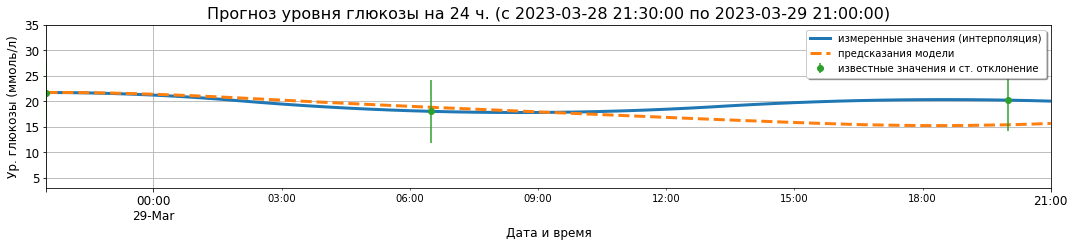

MAE для интервала с 2023-03-28 21:30:00 по 2023-03-29 21:00:00 составило 1.91 ммоль/л. Среднее MAE по выполненным итерациям: 3.2 ммоль/л


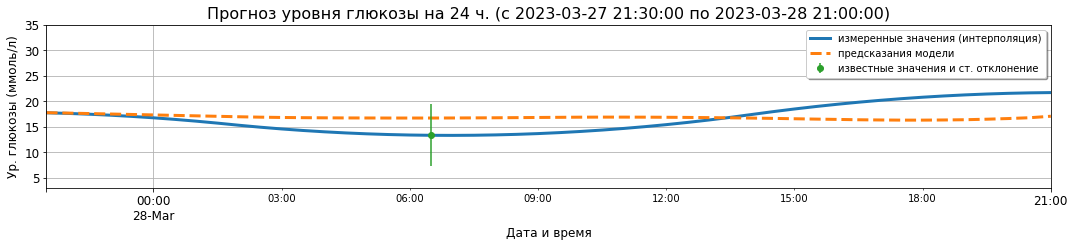

MAE для интервала с 2023-03-27 21:30:00 по 2023-03-28 21:00:00 составило 2.46 ммоль/л. Среднее MAE по выполненным итерациям: 3.19 ммоль/л


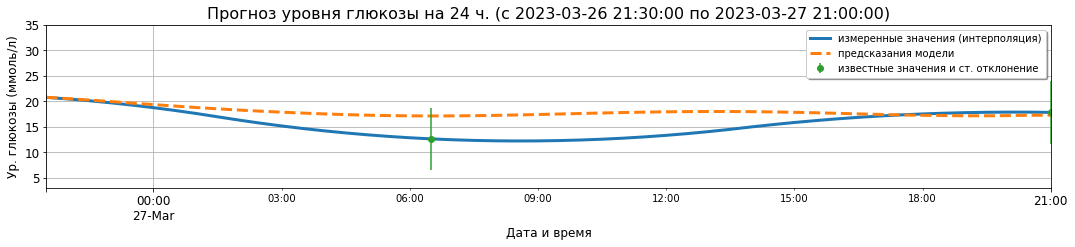

MAE для интервала с 2023-03-26 21:30:00 по 2023-03-27 21:00:00 составило 2.51 ммоль/л. Среднее MAE по выполненным итерациям: 3.18 ммоль/л


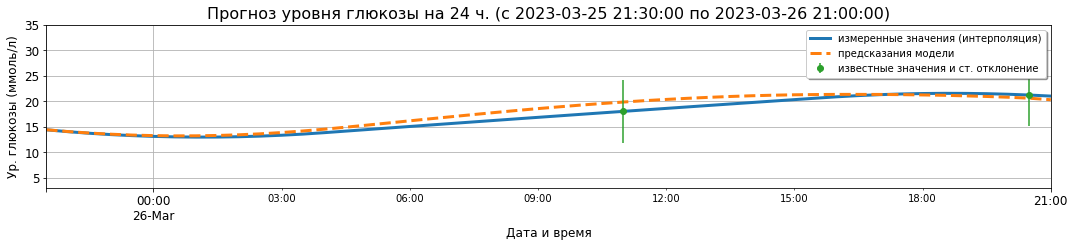

MAE для интервала с 2023-03-25 21:30:00 по 2023-03-26 21:00:00 составило 0.85 ммоль/л. Среднее MAE по выполненным итерациям: 3.15 ммоль/л


In [66]:
mae_mean = cv_plot(data, N, LAG, ROLLING, MIN_ROW)

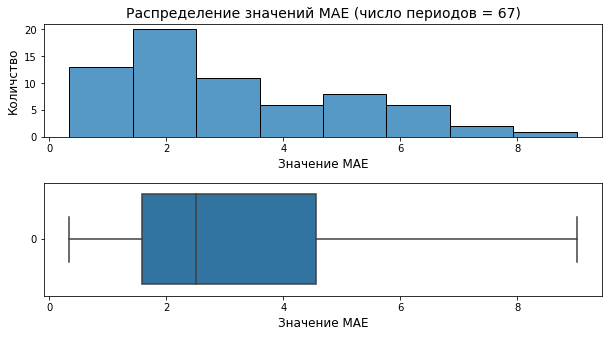

In [67]:
fig, axs = plt.subplots(figsize=[10,5], nrows=2)

sns.histplot(data=mae_mean, edgecolor = 'black', ax=axs[0])
axs[0].set_xlabel('Значение МАЕ', size=12)
axs[0].set_ylabel('Количство', size=12)
axs[0].set_title(f'Распределение значений МАЕ (число периодов = {len(mae_mean)})', size=14)

sns.boxplot(data=mae_mean, orient='h', ax=axs[1])
axs[1].set_xlabel('Значение МАЕ', size=12)
plt.subplots_adjust(hspace=0.4)

plt.show()

In [68]:
print(f'Медианное значение МАЕ составляет {np.median(mae_mean)} ммоль/л, среднее значение МАЕ составляет {round(np.mean(mae_mean), 2)} ммоль/л')

Медианное значение МАЕ составляет 2.51 ммоль/л, среднее значение МАЕ составляет 3.15 ммоль/л


Прогнозирование уровня глюкозы без за ранее известных значений (расширение набора данных)

In [69]:
# повторная загрузка данных
data = pd.read_excel('D:\datasets\insulin_31_05_23.xlsx')

# добавление строк с планируемым введением инсулина
new_rows = [
    {'injection_datetime': '2023-06-01 05:30:00', 'insulin_dose': 4.5},
    {'injection_datetime': '2023-06-01 19:30:00', 'insulin_dose': 3.5},
    {'injection_datetime': '2023-06-02 02:00:00', 'insulin_dose': 0},
    
]
data = data.append(new_rows, ignore_index=True)

# предобработка данных с помощью функции data_preprocessing
data = data_preprocessing(data)

In [70]:
# установим горизонт прогнозирования равным 30 часам
N = 30

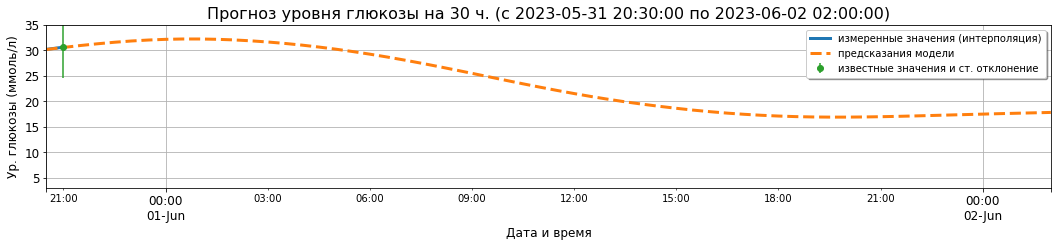

In [71]:
# получаем прогноз, применив функцию predict_glucose
target_true, target_predict = predict_glucose(data, N*2, LAG, ROLLING)

# строим график, применив функцию plotting_predict
plot = plotting_predict(target_true, target_predict)
plot.show()

**Общий вывод**

В данном проекте была изучена возможность прогнозирования уровня глюкозы в организме с использованием методов Data Science и Machine Learning. Полученные результаты демонстрируют, что применение методов машинного обучения позволяет достичь достаточно высокой точности прогнозирования уровня глюкозы.

В связи с небольшим размером выборки, используемые для прогнозирования уровня глюкозы модели, будут склонны к переобучению. Для устранения возможного переобучения в проекте использовалась Ridge регрессия (гребневая регрессия). В данной модели функция потерь является линейной функцией наименьших квадратов, а регуляризация задается L2-нормой. В применяемой модели константа alpha (которая умножает член L2, контролируя силу регуляризации) равна 1.5. Коэффициент alpha = 1.5 был определён путем подбора исходя из наименьшего полученного значения метрики.  Для сокращения времени на изучение и анализ данного проекта подбор оптимального коэффициента alpha не приводится. Выбор Ridge регрессии также был обусловлен наличием признаков, которые не являются независимыми друг от друга (коллинеарность). Устранить переобучение также возможно путём увеличения выборки, что может быть затруднительно в ввиду необходимости в значительных временных ресурсах. 

Полученные результаты: Стандартное отклонение имеющихся данных уровня глюкозы состаляет 6.11 ммоль/л. МАЕ на интервале в 24 часа определялось на основе сравнения полученных прогнозов модели и имеющихся данных (интерполяция). Среднее значение МАЕ для прогноза на следующие 24 часа составляет 3,15 ммоль/л. Медианное значение МАЕ составляет 2.51 ммоль/л. Межквартильный рамах ошибок составляет от 1,7 до 4,5 ммоль/л.

Основные результаты и выводы:

- Уровень глюкозы подвержен значительным изменениям в течении суток.

- Было выявлено влияние различных факторов на уровень глюкозы, таких как время дня, день недели и тип дня (будний или праздничный).

- Разработана модель прогнозирования уровня глюкозы, которая позволяет предсказывать будущие значения на основе исторических данных и ранее известных факторов.

- Модель демонстрирует хорошую точность прогнозирования, что может быть полезным инструментом для контроля и управления уровнем глюкозы.

В целом, проект позволяет лучше понять факторы, влияющие на уровень глюкозы и разработать эффективные стратегии заместительной инсулинотерапии. Это открывает возможности для более эффективного управления сахарным диабетом и улучшения качества жизни.


**Важно помнить**, что использованные методы прогнозирования уровня глюкозы не заменяют профессионального медицинского мнения и врачебного наблюдения! Регулярное посещение ветеринарного врача являются ключевыми фактором в эффективной борьбе с сахарным диабетом у животных.